In [1]:
import sys
import json
params = {}
default = {'training_folder': '../../scenarios/houston/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/houston/', 'params': {}}


In [2]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

PyTables is not installed. No support for HDF output.
num cores: 8


In [3]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

In [4]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(input_folder, 'model/')

In [5]:
sm = stepmodel.read_zippedpickles(model_folder +'los')
sm.segments = ['car_owner', 'pt_captive'] 

zones: 100%|██████████| 28/28 [00:06<00:00,  4.39it/s]              


In [6]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario='base', return_ancestry=False)
kwargs = var['preparation_logit'].to_dict()

utility_scale = var['preparation_logit']['time']
kwargs['transfers'] = -kwargs['transfers']/utility_scale # From min/transfer to pt/transfer
kwargs['price'] = -60/kwargs['price']/utility_scale # From 
kwargs['time'] = -1/utility_scale/60 # From min/pt to pt/sec
kwargs


{'time': -0.0008333333333333334,
 'price': -0.2,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1,
 'transfers': -0.25}

In [7]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [8]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.000833,-0.2,-0.25,1.0
car_owner,-0.000833,-0.2,-0.25,1.0
pt_captive,-0.000833,-0.2,-0.25,1.0


In [9]:
sm.logit_scales.T 

route_type,bus,tram,root,walk,car,pt
segment,,,,,,
root,0.1,0.1,1.0,0.0,0.0,0.5
car_owner,0.1,0.1,1.0,0.0,0.0,0.5
pt_captive,0.1,0.1,1.0,0.0,0.0,0.5


In [10]:
sm.mode_utility.T

route_type,bus,tram,root,walk,car
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,0,0,0,0


In [11]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility.T

route_type,bus,tram,root,walk,car
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,0,0,0,-100


In [12]:
sm.mode_nests.T 

route_type,bus,tram,root,walk,car,pt
segment,,,,,,
root,pt,pt,NaN,root,root,root
car_owner,pt,pt,NaN,root,root,root
pt_captive,pt,pt,NaN,root,root,root


In [13]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0  ######
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

In [14]:
sm.analysis_pt_time(
        boarding_time=None,
        alighting_time=None,
        walk_on_road=True,
    )
 

sm.analysis_car_route_type() 

sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) 


sm.analysis_mode_utility()

100%|██████████| 2/2 [00:00<00:00, 28.43it/s]


In [15]:
sm.initialize_logit()
sm.step_logit()

100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


In [16]:
sm.volumes.fillna(0, inplace=True)
sm.compute_los_volume(keep_segments=False)

In [17]:
sm.los['volume'].sum()

3574545.4992814944

In [18]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']

In [19]:
sm.step_pt_assignment(
    road=True,
    boardings=True,
    alightings=True,
    transfers=True
 
)

pt_captive: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


In [20]:
sm.links.rename(columns={'load': 'volume'}, inplace=True)
sm.analysis_pt_length(
     walk_on_road=True
)
sm.analysis_car_length()
sm.analysis_pt_time(
     walk_on_road=True
)

In [21]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

In [22]:
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [23]:
sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [24]:
sm.probabilities.groupby(['segment'])['pt'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
car_owner,67780.0,0.004983,0.021535,0.0,1.829612e-12,4.691556e-07,0.000312,0.406207
pt_captive,67780.0,0.918899,0.272992,0.0,1.000000e+00,1.000000e+00,1.000000,1.000000


In [25]:
sm.probabilities.loc[sm.probabilities['segment'] == 'car_owner'].sort_values(by='pt', ascending=False).head()

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
12502,zone_58,zone_242,car_owner,1,0.593793,0.0,0.406207,0.0,0.406207
9482,zone_416,zone_154,car_owner,1,0.617625,0.0,0.382375,0.0,0.382375
5048,zone_274,zone_196,car_owner,1,0.617954,0.0,0.382046,0.0,0.382046
4320,zone_196,zone_274,car_owner,1,0.628041,0.0,0.371959,0.0,0.371959
10720,zone_445,zone_109,car_owner,1,0.629095,0.0,0.370905,0.0,0.370905


In [26]:
sm.links['boardings'].sum()


1804819.6103978134

In [27]:
sm.car_los

,origin,destination,time,path,gtime,node_path,link_path,ntlegs,ntransfers,price,route_types,route_type,access_length,in_vehicle_length,length
0,zone_47,zone_211,3736.914187,"[zone_47, road_node_74772, road_node_26113, ro...",3736.914187,"[road_node_74772, road_node_26113, road_node_4...","[road_link_61614, road_link_48360, road_link_6...","[(zone_47, road_node_74772), (road_node_48579,...",0,0,"(car,)",car,935.614199,67998.476337,68934.090536
1,zone_389,zone_17,2127.068195,"[zone_389, road_node_90495, road_node_30071, r...",2127.068195,"[road_node_90495, road_node_30071, road_node_3...","[road_link_14226, road_link_14227, road_link_1...","[(zone_389, road_node_90495), (road_node_67964...",0,0,"(car,)",car,391.571624,41803.204900,42194.776524
2,zone_139,zone_179,31245.142157,"[zone_139, road_node_2797, road_node_18377, ro...",31245.142157,"[road_node_2797, road_node_18377, road_node_69...","[road_link_49351_r, road_link_57196_r, road_li...","[(zone_139, road_node_2797), (road_node_22083,...",0,0,"(car,)",car,21683.979596,83544.256133,105228.235728
3,zone_283,zone_421,3393.760867,"[zone_283, road_node_69770, road_node_60574, r...",3393.760867,"[road_node_69770, road_node_60574, road_node_1...","[road_link_68459, road_link_5991, road_link_59...","[(zone_283, road_node_69770), (road_node_18982...",0,0,"(car,)",car,556.403304,70485.054772,71041.458076
4,zone_307,zone_401,2885.435191,"[zone_307, road_node_67101, road_node_22233, r...",2885.435191,"[road_node_67101, road_node_22233, road_node_4...","[road_link_68070, road_link_39501, road_link_6...","[(zone_307, road_node_67101), (road_node_65433...",0,0,"(car,)",car,541.834859,57016.874555,57558.709414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67775,zone_165,zone_68,1545.047217,"[zone_165, road_node_26319, road_node_76416, r...",1545.047217,"[road_node_26319, road_node_76416, road_node_6...","[road_link_8310_r, road_link_36443, road_link_...","[(zone_165, road_node_26319), (road_node_75329...",0,0,"(car,)",car,747.506480,12851.473888,13598.980368
67776,zone_85,zone_475,4257.982388,"[zone_85, road_node_85326, road_node_11590, ro...",4257.982388,"[road_node_85326, road_node_11590, road_node_6...","[road_link_54871, road_link_55631, road_link_2...","[(zone_85, road_node_85326), (road_node_9105, ...",0,0,"(car,)",car,1616.721026,47668.241680,49284.962706
67777,zone_2,zone_482,3939.032038,"[zone_2, road_node_11771, road_node_72777, roa...",3939.032038,"[road_node_11771, road_node_72777, road_node_7...","[road_link_56618, road_link_49835, road_link_9...","[(zone_2, road_node_11771), (road_node_58052, ...",0,0,"(car,)",car,971.568430,70769.782778,71741.351208
67778,zone_231,zone_412,1683.494048,"[zone_231, road_node_47866, road_node_10158, r...",1683.494048,"[road_node_47866, road_node_10158, road_node_5...","[road_link_51327, road_link_16021, road_link_6...","[(zone_231, road_node_47866), (road_node_32216...",0,0,"(car,)",car,240.273956,33205.109703,33445.383659


In [28]:
sm.utilities

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
0,zone_0,zone_1,car_owner,-2.871049,-2.871404,-inf,-10.815036,-inf,-10.815036
1,zone_0,zone_1,pt_captive,-10.815036,-102.871404,-inf,-10.815036,-inf,-10.815036
2,zone_0,zone_104,car_owner,-1.186995,-1.193814,-inf,-6.178421,-inf,-6.178421
3,zone_0,zone_104,pt_captive,-6.178421,-101.193814,-inf,-6.178421,-inf,-6.178421
4,zone_0,zone_109,car_owner,-2.281372,-2.288714,-inf,-7.199089,-inf,-7.199089
...,...,...,...,...,...,...,...,...,...
12709,zone_79,zone_75,pt_captive,-26.853956,-103.615808,-inf,-26.853956,-26.853956,-inf
12710,zone_79,zone_77,car_owner,-2.617288,-2.617288,-inf,-24.226461,-inf,-24.226461
12711,zone_79,zone_77,pt_captive,-24.226461,-102.617288,-inf,-24.226461,-inf,-24.226461
12712,zone_79,zone_87,car_owner,-2.988081,-2.988081,-inf,-25.930821,-inf,-25.930821


In [29]:
sm.probabilities

route_type,origin,destination,segment,root,car,walk,pt,tram,bus
0,zone_0,zone_1,car_owner,1,9.996452e-01,0.0,3.547894e-04,0.0,3.547894e-04
1,zone_0,zone_1,pt_captive,1,1.048159e-40,0.0,1.000000e+00,0.0,1.000000e+00
2,zone_0,zone_104,car_owner,1,9.932040e-01,0.0,6.795962e-03,0.0,6.795962e-03
3,zone_0,zone_104,pt_captive,1,5.436750e-42,0.0,1.000000e+00,0.0,1.000000e+00
4,zone_0,zone_109,car_owner,1,9.926842e-01,0.0,7.315814e-03,0.0,7.315814e-03
...,...,...,...,...,...,...,...,...,...
12709,zone_79,zone_75,pt_captive,1,4.599929e-34,0.0,1.000000e+00,1.0,0.000000e+00
12710,zone_79,zone_77,car_owner,1,1.000000e+00,0.0,4.123398e-10,0.0,4.123398e-10
12711,zone_79,zone_77,pt_captive,1,9.021870e-35,0.0,1.000000e+00,0.0,1.000000e+00
12712,zone_79,zone_87,car_owner,1,1.000000e+00,0.0,1.086663e-10,0.0,1.086663e-10


In [30]:
sm.od_los

segment                  car_owner                                   \
sum                         volume price       time in_vehicle_time   
origin  destination mode                                              
zone_0  zone_1      bus   0.008931   0.0   4.285161        1.885705   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_104    bus   0.684262   0.0  46.308404       32.382759   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_109    bus   0.367206   0.0  56.616397       30.689838   
...                            ...   ...        ...             ...   
zone_99 zone_85     car   0.000000   0.0   0.000000        0.000000   
        zone_87     bus   0.000002   0.0   0.001500        0.000256   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_90     car   0.000000   0.0   0.000000        0.000000   
                    walk  0.000001   0.0   0.000584        0.000000   

segment                                                  pt_captive        \
sum                      in_vehicle_length    ntransfers     volume price   
origin  destination mode                                                    
zone_0  zone_1      bus          29.907679  1.064368e-03   0.000000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_104    bus         208.391380  1.359192e-02  50.702857   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_109    bus         434.771484  2.194744e-02   0.000000   0.0   
...                                    ...           ...        ...   ...   
zone_99 zone_85     car           0.000000  0.000000e+00   0.000000   0.0   
        zone_87     bus           0.003252  6.439803e-08  25.475000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_90     car           0.000000  0.000000e+00   0.000000   0.0   
                    walk          0.000000  0.000000e+00   0.000000   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_1      bus   12078.042640          5315.0           84297.0   
                    car       0.000000             0.0               0.0   
        zone_104    bus    6814.105732          4765.0           30664.0   
                    car       0.000000             0.0               0.0   
        zone_109    bus    7738.906510          4195.0           59429.0   
...                                ...             ...               ...   
zone_99 zone_85     car       0.000000             0.0               0.0   
        zone_87     bus   23299.386085          3970.0           50504.0   
                    car       0.000000             0.0               0.0   
        zone_90     car       0.000000             0.0               0.0   
                    walk  24321.227058             0.0               0.0   

segment                                   root                      \
sum                      ntransfers     volume price          time   
origin  destination mode                                             
zone_0  zone_1      bus         3.0   0.008931   0.0      4.285161   
                    car         0.0   0.000000   0.0      0.000000   
        zone_104    bus         2.0  51.387119   0.0   6723.986938   
                    car         0.0   0.000000   0.0      0.000000   
        zone_109    bus         3.0   0.367206   0.0     56.616397   
...                             ...        ...   ...           ...   
zone_99 zone_85     car         0.0   0.000000   0.0      0.000000   
        zone_87     bus         1.0  25.475002   0.0  23299.384609   
                    car         0.0   0.000000   0.0      0.000000   
        zone_90     c

In [31]:
sm.to_zippedpickles(model_folder + 'logit_assignment')

orphan_nodes:  15%|█▍        | 7/47 [00:00<00:00, 69.75it/s]

stack_aggregated_link_max: 100%|██████████| 47/47 [00:29<00:00,  1.60it/s]


In [32]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined

In [33]:
od_test = gpd.read_file(od_folder + 'od.geojson')
from shapely.geometry import Point
from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))
# find nearest node with KNN. nodes are now the origin and destination.
od_test['geometry'] = od_test['geometry_o']
neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['origin'] = od_test.index.map(zone_node_dict.get)

od_test['geometry'] = od_test['geometry_d']
neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['destination'] = od_test.index.map(zone_node_dict.get)

od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])
od_test = od_test.drop(columns=['index'])
od_test


,name,origin,destination
0,iah_to_houston,zone_174,zone_488
1,houston_to_westUniversity,zone_488,zone_4
2,pasadena_to_houston,zone_299,zone_488
3,jersey_to_UniversityOfHouston,zone_176,zone_298
4,bunkerVillage_to_memorialGolfCourse,zone_203,zone_247
5,houstonHeights_to_riceUniversity,zone_411,zone_129
6,riceMilitary_to_jacintoCity,zone_137,zone_144
7,bellaire_to_magnoliaPark,zone_386,zone_300
8,IWS_to_highlandHeights,zone_239,zone_443
9,westwoodPark_to_scenicWoods,zone_446,zone_83


In [34]:
od_list = sm.volumes.loc[sm.volumes['pt_captive']==0.001][['origin','destination']]
od_list['name'] = od_test['name']
od_list = od_list.values.tolist()
od_list

[['zone_446', 'zone_83', 'westwoodPark_to_scenicWoods'],
 ['zone_239', 'zone_443', 'IWS_to_highlandHeights'],
 ['zone_386', 'zone_300', 'bellaire_to_magnoliaPark'],
 ['zone_137', 'zone_144', 'riceMilitary_to_jacintoCity'],
 ['zone_488', 'zone_4', 'houston_to_westUniversity'],
 ['zone_203', 'zone_247', 'bunkerVillage_to_memorialGolfCourse'],
 ['zone_176', 'zone_298', 'jersey_to_UniversityOfHouston'],
 ['zone_174', 'zone_488', 'iah_to_houston'],
 ['zone_382', 'zone_179', 'alief_to_sprinBranchWest']]

In [35]:
sm.pt_los.set_index(['origin','destination']).loc[od_list]

,,gtime,path,pathfinder_session,reversed,route_id_set,route_type_set,boardings,alightings,node_path,link_path,...,"(car_owner, probability)","(pt_captive, probability)",car_owner,pt_captive,volume,pivot,access_length,footpath_length,in_vehicle_length,length
origin,destination,,,,,,,,,,,,,,,,,,,,,
zone_446,zone_83,8003.531299,"(zone_446, 3455, link_1355, link_1356, link_13...",best_path,False,"{HOU_003, HOU_008}","{bus, tram}","[3455, 1786, 512]","[460, 512, 629]","[3455, 460, 1786, 512, 629]","[link_1355, link_1356, link_1357, link_1358, l...",...,0.003459,1.0,0.0,0.001,0.001,1.0,501.978521,343.431511,34363.0,35208.410032
zone_239,zone_443,12516.741854,"(zone_239, road_node_28422, road_node_60745, r...",best_path,False,"{HOU_228, HOU_096}",{bus},"[2270, 1014, 1115]","[4162, 817, 673]","[road_node_28422, road_node_60745, road_node_3...","[link_12043, link_12044, link_12045, link_1204...",...,0.000091,1.0,0.0,0.001,0.001,1.0,256.229925,8924.078173,44622.0,53802.308098
zone_386,zone_300,4903.993637,"(zone_386, road_node_30783, road_node_63616, r...",best_path,False,"{HOU_009, HOU_050}",{bus},"[64, 845]","[845, 377]","[road_node_30783, road_node_63616, road_node_9...","[link_1446, link_1447, link_1448, link_1449, l...",...,0.037026,1.0,0.0,0.001,0.001,1.0,485.930039,747.826052,19473.0,20706.756091
zone_137,zone_144,5000.791272,"(zone_137, road_node_56631, road_node_81882, r...",best_path,False,"{HOU_137, HOU_020}",{bus},"[139, 2997]","[2997, 2853]","[road_node_56631, road_node_81882, road_node_5...","[link_2026, link_2027, link_2028, link_2029, l...",...,0.035055,1.0,0.0,0.001,0.001,1.0,443.487289,1270.439679,17563.0,19276.926968
zone_488,zone_4,4447.897741,"(zone_488, 1357, link_4793, link_4794, link_47...",best_path,False,"{HOU_002, HOU_044}","{bus, tram}","[1357, 2882, 2009]","[1234, 1016, 1368]","[1357, 1234, 2882, 1016, 2009, 1368]","[link_4793, link_4794, link_4795, link_4796, l...",...,0.036056,1.0,0.0,0.001,0.001,1.0,766.189707,254.320738,11462.0,12482.510445
zone_203,zone_247,5358.580717,"(zone_203, 1170, link_7924, link_7925, link_79...",best_path,False,"{HOU_070, HOU_085}",{bus},"[1170, 804]","[129, 1439]","[1170, 129, 804, 1439]","[link_7924, link_7925, link_7926, link_7927, l...",...,0.017761,1.0,0.0,0.001,0.001,1.0,1126.854963,97.681698,10169.0,11393.536660
zone_176,zone_298,8587.585470,"(zone_176, road_node_2114, road_node_62594, ro...",best_path,False,"{HOU_216, HOU_029}","{bus, tram}","[2364, 1379, 1392]","[1379, 1392, 1391]","[road_node_2114, road_node_62594, road_node_73...","[link_12013, link_12014, link_12015, link_1201...",...,0.005216,1.0,0.0,0.001,0.001,1.0,1236.938982,2413.147223,35905.0,39555.086205
zone_174,zone_488,4846.048396,"(zone_174, 2016, link_11081, link_11082, link_...",best_path,False,"{HOU_102, HOU_044}",{bus},"[2016, 3987]","[2169, 1357]","[2016, 2169, road_node_66212, road_node_38818,...","[link_11081, link_11082, link_11083, link_1108...",...,0.065188,1.0,0.0,0.001,0.001,1.0,328.185686,101.327571,42982.0,43411.513257
zone_382,zone_179,3781.322122,"(zone_382, 108, link_174, link_175, link_176, ...",best_path,False,"{HOU_002, HOU_046}",{bus},"[108, 1794]","[2298, 789]","[108, 2298, 1794, 789]","[link_174, link_175, link_176, link_177, link_...",...,0.065914,1.0,0.0,0.001,0.001,1.0,189.920321,159.957781,15878.0,16227.878102


In [36]:
sm.probabilities.set_index(['segment', 'origin', 'destination']).loc['car_owner'].loc[od_list]

,route_type,root,car,walk,pt,tram,bus
origin,destination,,,,,,
zone_446,zone_83,1,0.996541,0.0,0.003459,0.003459,0.000000
zone_239,zone_443,1,0.999909,0.0,0.000091,0.000000,0.000091
zone_386,zone_300,1,0.962974,0.0,0.037026,0.000000,0.037026
zone_137,zone_144,1,0.964945,0.0,0.035055,0.000000,0.035055
zone_488,zone_4,1,0.963944,0.0,0.036056,0.036056,0.000000
zone_203,zone_247,1,0.982239,0.0,0.017761,0.000000,0.017761
zone_176,zone_298,1,0.994784,0.0,0.005216,0.005216,0.000000
zone_174,zone_488,1,0.934812,0.0,0.065188,0.000000,0.065188
zone_382,zone_179,1,0.934086,0.0,0.065914,0.000000,0.065914


In [39]:
sm.links['boardings'].sum()

1804819.6103978134

In [40]:
sm.links['volume'].max()

45115.47135845348

In [41]:
sm.volumes['pt_captive'].sum()

714964.2089999998

In [42]:
sm.volumes['car_owner'].sum()

2859581.290281494

In [43]:

import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

In [46]:
plot_sm = sm.copy()

In [47]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)

In [48]:
sm3857 = sm.change_epsg(epsg =3857, coordinates_unit = 'meter')
sm3857.pt_los = pd.concat([sm3857.pt_los, sm3857.pt_los])

Reprojecting model from epsg 32615 to epsg 3857: 100%|██████████| 47/47 [00:10<00:00,  4.45it/s]


In [ ]:
        fig, axes = sm3857.plot_one_path(
            origin, destination, rows=rows, figsize=[20, 20], basemap_url= url,
            title= 'title', constrained_layout=True, zoom=13
        )

AttributeError: 'StepModel' object has no attribute 'plot_one_path'

westwoodPark_to_scenicWoods


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

could not add basemap: 'NoneType' object has no attribute 'shape'


AssertionError: 

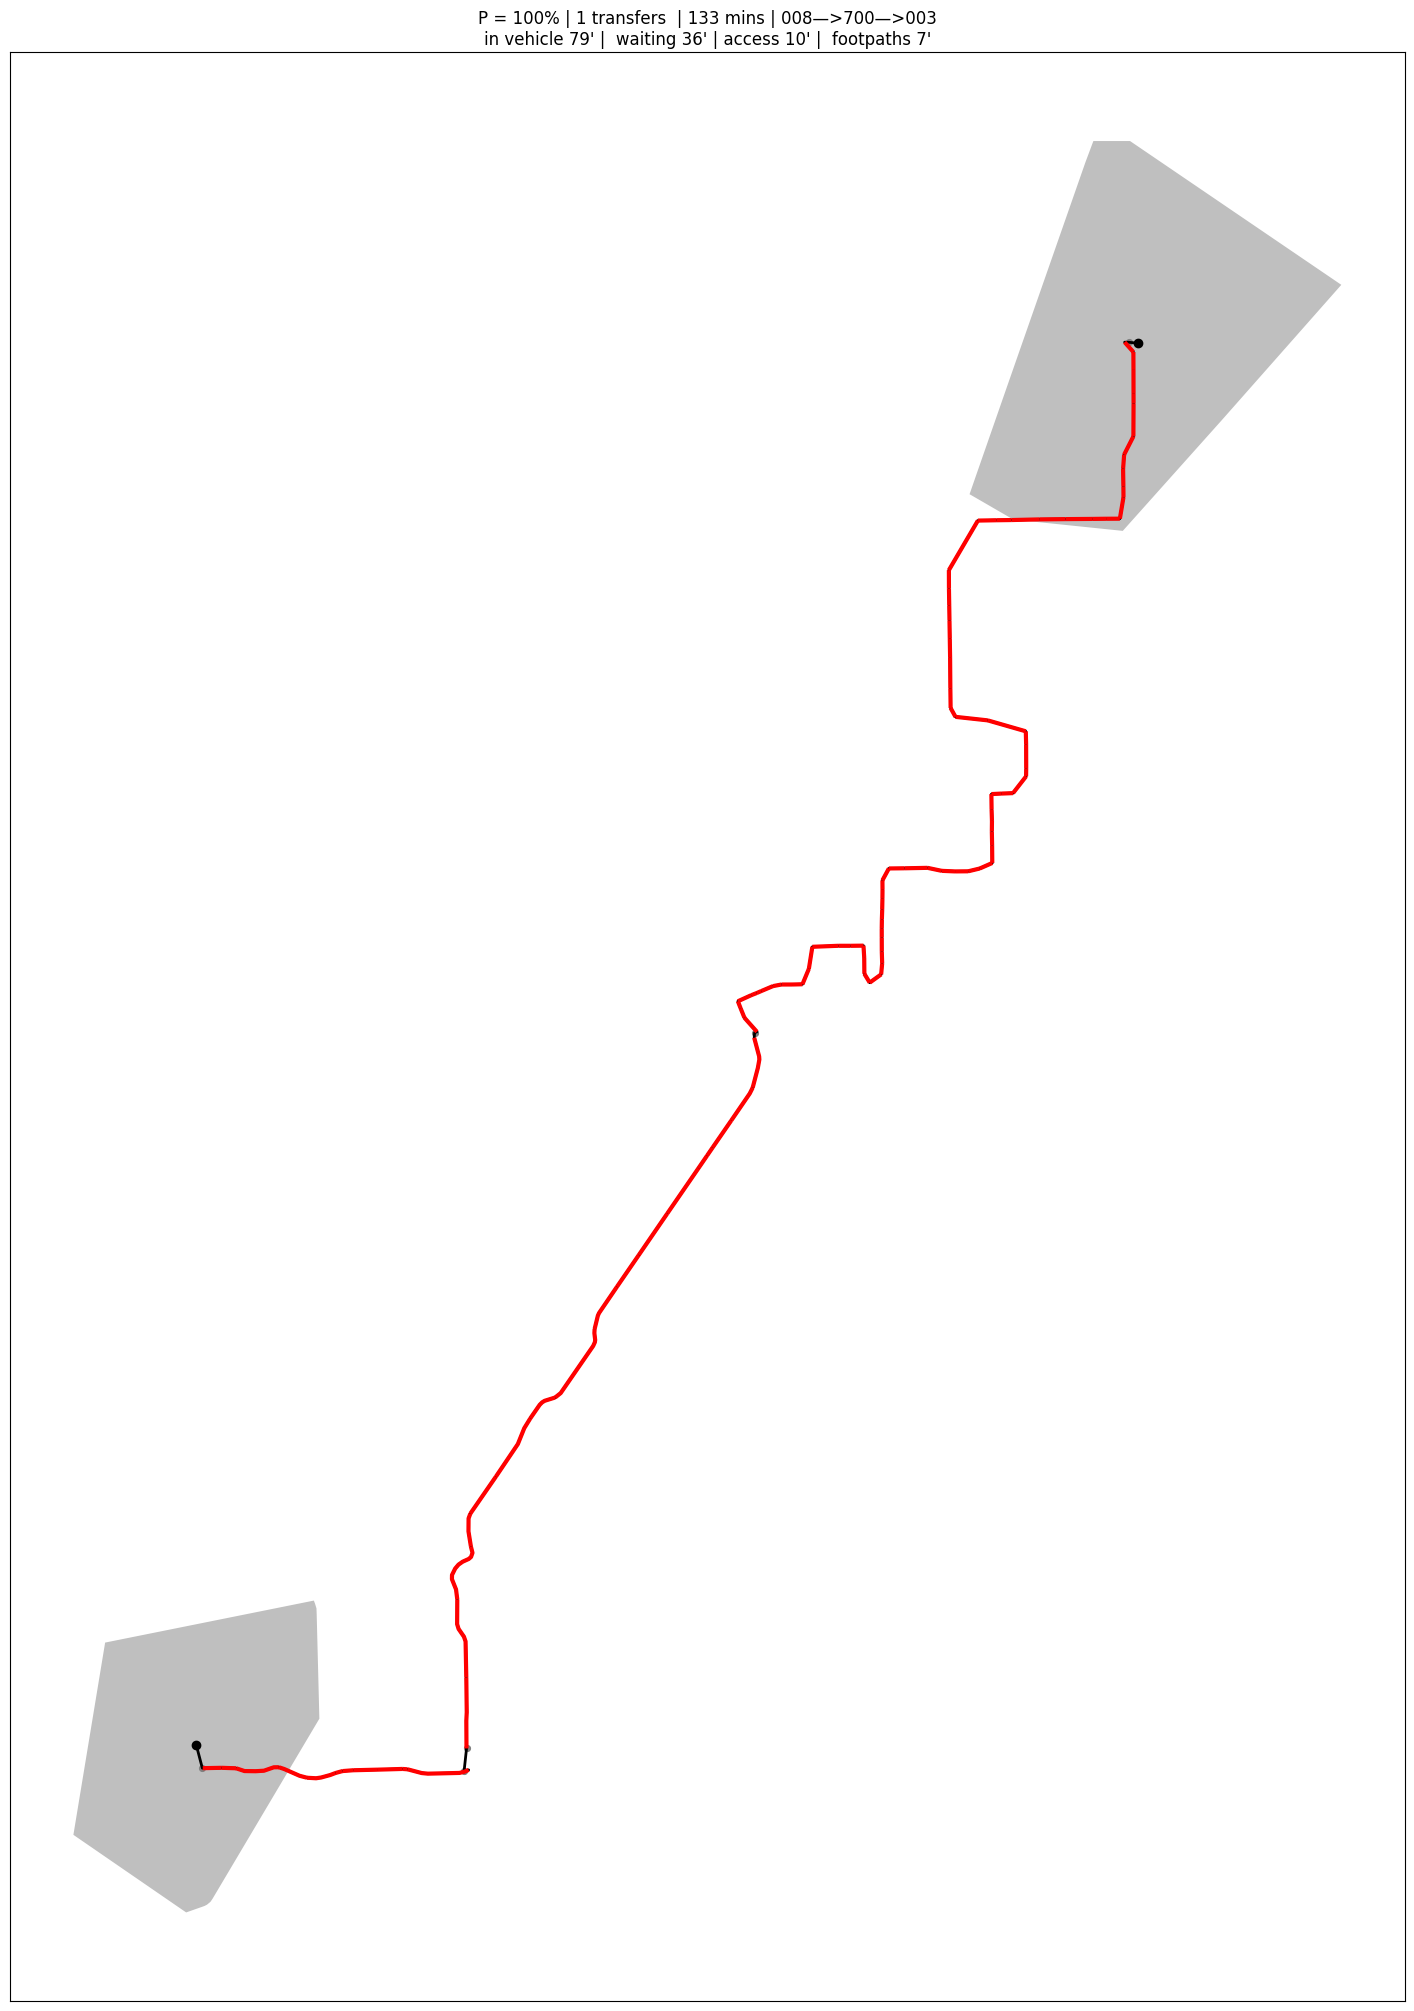

In [52]:
if manual:

    for o,d, name in od_list[:1]:
        origin, destination= o, d
        n =  len(sm3857.pt_los.set_index(['origin', 'destination']).loc[[(origin, destination)]])

        
        rows = 1
        columns = 2


        print(name)

        url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
        fig, axes = sm3857.plot_separated_paths(
            origin, destination, rows=rows, figsize=[10, 10], basemap_url= url,
            title= 'title', constrained_layout=True, zoom=10, errors = 'wtv'
        )

        '''
        png = base_folder+ 'OD_googlemaps/' +name + '.png'


        from IPython.display import Image
        from IPython.display import display
        display (Image(filename=png) )
        
        '''